In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import networkx as nx

# Fake data

Time series of ROIs for all participant

In [103]:
# Simulate 8-ROI binarized brain dynamics (e.g., Ising-like)
import numpy as np

np.random.seed(42)
ROI = 8
l_t = 5000

# Create correlated binary activity
data_p = np.random.randint(0, 2, size=(ROI, l_t))
data_p[:, 1:] = (data_p[:, :-1] + np.random.randint(0, 2, size=(ROI, l_t-1))) % 2

data_p.shape

#data_p.T[t] -----> v_t , activity pattern for each participate in a specific time

(8, 5000)

# Real data

binarized data(with binary values = 0 or 1)
\
shape of data must be t*ROI or you can edit the following cell to adjust the format with your data.

In [104]:
import pandas as pd

df = pd.read_csv('/path/your_file.csv')

# Show first few rows
df.head()


,Unnamed: 0,0,1,2,3,4,5,6,7,Subject,Type
0,0,1,1,0,1,1,0,1,0,1,Latchers
1,1,1,1,1,1,0,0,1,1,1,Latchers
2,2,1,1,0,0,0,0,1,0,1,Latchers
3,3,0,1,1,0,1,0,0,0,1,Latchers
4,4,1,1,1,1,0,0,0,1,1,Latchers


In [106]:
df = df.drop(columns=['Unnamed: 0', 'Subject', 'Type'])
df = np.array(df)
data_p = df.T

In [107]:
l_t = len(data_p.T)
ROI = np.shape(data_p)[0]
np.shape(data_p) #format of data must be ROI*t

(8, 5780)

# model fitting

finding H and J

In [108]:
'you can change the eps, alpha and beta inside the function.'

def HandJ(data_p, ROI, l_t):

  #parameters
  expected_value = np.zeros(ROI)
  correlation_value = np.zeros((ROI,ROI))
  for i in range(ROI):
    expected_value[i] = np.sum(data_p[i])/l_t #mean for a specific ROI over time, also it is y data
    for j in range(ROI):
      correlation_value[i][j] = np.dot(data_p[i], data_p[j])/l_t


  eps = 0.000001
  e = 1e-8
  #learning rate
  alpha = 0.1
  beta = alpha

  #initial data
  H_rand = np.array([1,1,1,1,1,1,1,1]) *0.1
  J_rand = np.ones((ROI,ROI)) *0.1
  np.fill_diagonal(J_rand, 0)

  #all possible pattern
  sigma = [0,1]
  V = np.array(list(itertools.product(sigma, repeat = ROI))) #(2^ROI, ROI)

  E_rand = -1 * np.dot(H_rand, V.T) - 0.5 * np.diag(np.dot(np.dot(V,J_rand), V.T))
  P_rand = np.exp(-E_rand)/np.sum(np.exp(-E_rand))

  model_expected = np.dot(V.T,P_rand)
  model_corrolation = np.dot(P_rand * V.T, V)
  i = 0
  H_rand_old = np.copy(H_rand)

  #initial condition for starting the while loop.
  cond6 = 100
  cond7 = 100


  while cond6 > eps and  cond7 > eps:
    H_rand_old = np.copy(H_rand)
    J_rand_old = np.copy(J_rand)

    H_rand += alpha * np.log((expected_value / (model_expected + e)))
    J_rand += beta * np.log((correlation_value / (model_corrolation + e)))

    E_rand = -1 * np.dot(H_rand, V.T) - 0.5 * np.diag(np.dot(np.dot(V,J_rand), V.T))
    P_rand = np.exp(-E_rand)/np.sum(np.exp(-E_rand))
    model_expected = np.dot(V.T,P_rand)
    model_corrolation = np.dot(P_rand * V.T, V)

    cond4 = np.sum(abs(alpha  * np.log(((model_expected+e)/(expected_value)))))/8
    cond6 = np.sum(abs((H_rand-H_rand_old)))/8
    cond7 = np.sum(abs(J_rand-J_rand_old))/64
  np.fill_diagonal(J_rand,0)
  return H_rand, J_rand

In [109]:
np.diag(HandJ(data_p, ROI, l_t)[1])

array([0., 0., 0., 0., 0., 0., 0., 0.])

# Identification of local minima

In [110]:
#function for making the disconnectivity graph, energy landscape

def landscape(data_p):
  'V is array of all possible activity pattern'
  #we have 2^ROI possible patterns = V_k (1 <= k <= 2^ROI)
  sigma = [0,1]
  V = np.array(list(itertools.product(sigma, repeat = ROI)))

  'dis_grap is a adjanency matrix of disconectivity graph, E is an array, demonstrating energy of all possible pattern(V)'
  #energ : E(V_k) = -sum_from 1 to ROI(h_i * sigma_i) -0.5 * sum_from 1 to ROI _ sum_from 1 to ROI (J_ij * sigma_i * sigma_j)

  dis_graph = np.zeros((2**ROI,2**ROI))
  E = np.zeros(2**ROI)

  H_rand, J_rand = HandJ(data_p, ROI, l_t)
  E = -1 * np.dot(H_rand, V.T) - 0.5 * np.diag(np.dot(np.dot(V,J_rand), V.T))

  for i in range(2**ROI):
    V_k = V[i]
    for j in range(2**ROI):
      metric = np.sum(abs(V[i]-V[j]))
      if metric == 1:
        dis_graph[i][j] = 1

  # probability
  P = np.exp(-E)/np.sum(np.exp(-E))

  return P, E, dis_graph


P, E, dis_graph = landscape(data_p)
G = nx.from_numpy_array(dis_graph)
# nx.draw(G)

In [111]:
#function for finding the local minima in the graph based on its energy landscape
def local_minima(dis_graph, E):
  local_min_E = []
  local_min_arg = []
  for i in range(len(E)):
    E_now = E[i]
    args_neig = np.where(dis_graph[i] == 1)[0]
    E_neig = E[args_neig]
    if np.all(E_now < E_neig):
      local_min_E = local_min_E + [E_now]
      local_min_arg = local_min_arg + [i]
  return local_min_E, local_min_arg


local_min_E, local_min_arg = local_minima(dis_graph, E)
print(local_min_E, local_min_arg)

[np.float64(-0.0), np.float64(-0.985400415340671), np.float64(-1.7428860916184776)] [0, 183, 255]


In [112]:
#checking existance of path in the graph
def is_path_exist(graph, start_node, end_node):
    return int(nx.has_path(graph, start_node, end_node))



def con_local_min(dis_graph, local_min_arg):
    """Construct a connectivity matrix between local minima based on graph connectivity."""
    g = nx.from_numpy_array(dis_graph)
    n = len(local_min_arg)
    con_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            start_node = local_min_arg[i]
            end_node = local_min_arg[j]
            if is_path_exist(g, start_node, end_node) == 1:
                con_mat[i][j] = 1
    return con_mat


In [113]:
def dendo_data():
  """Reduce the graph based on energy thresholds and isolate local minima."""
  E_copy = np.copy(E)
  dis_graph_copy = np.copy(dis_graph)
  local_min_arg_copy = np.copy(local_min_arg)
  E_isolated = []
  arg_isolated = []

  con_matrix = con_local_min(dis_graph_copy, local_min_arg_copy)
  con_mat_patterns = []
  patterns = [con_matrix]

  while np.sum(con_matrix) >= len(con_matrix):
      if E_copy.size == 0:  # Check if E_copy is empty
        break
      E_th = E_copy.max()  # Set threshold to the maximum energy value
      to_remove = []
      to_remove_mat = []

      # Remove nodes whose energy values are >= E_th
      for i in range(len(E_copy)):
          if E_copy[i] >= E_th:
              to_remove.append(i)

      values_to_remove = E_copy[to_remove]

      # Find indices in E that match the values in values_to_remove
      to_remove_mat = np.where(np.isin(E, values_to_remove))[0]

      # Delete nodes and corresponding edges in the graph
      E_copy = np.delete(E_copy, to_remove)
      # Set the specified rows to 0
      dis_graph_copy[to_remove_mat, :] = 0

      # Set the specified columns to 0
      dis_graph_copy[:, to_remove_mat] = 0


      # Check connectivity among remaining local minima
      E_th_copy = np.copy(E_th)
      con_mat_patterns = np.copy(con_matrix)
      con_matrix = con_local_min(dis_graph_copy, local_min_arg_copy)
      # print(con_matrix, E_th)
      if np.sum(con_matrix)!= np.sum(con_mat_patterns):
        patterns.append(con_matrix)
        E_isolated.append(E_th)

  list_dendo = [set() for _ in range(len(patterns))]
  for i in range(len(patterns)):
      g = nx.from_numpy_array(patterns[i])
      for j in range(len(local_min_arg)):
          for k in range(j+1, len(local_min_arg)):  # Avoid duplicate pairs and self-loops
              if is_path_exist(g, j, k) == 0:
                  list_dendo[i].add((j, k))

  print("isolated local minima from each other in each step:")
  for i in range(len(list_dendo)):
    print("step:",i,list_dendo[i])

  print("")
  print("Energy that caused isolation at each step:")
  for i in range(len(E_isolated)):
    print("step:",i,E_isolated[i])

  return patterns, list_dendo, E_isolated

patterns, list_dendo, E_isolated = dendo_data()

isolated local minima from each other in each step:
step: 0 set()
step: 1 {(0, 1), (0, 2)}
step: 2 {(0, 1), (0, 2), (1, 2)}

Energy that caused isolation at each step:
step: 0 0.015059458116672052
step: 1 -0.8213811896556473


#Apearance probability for empirical data and model

In [114]:
data_p = np.array(data_p)  # if it's a list of lists, this will still become object if inner lists vary
print(data_p.shape)
print(data_p.dtype)


(8, 5780)
int64


In [115]:
#function for finding the empirical probability of patterns
def Prob_emp(data_p):
  sigma = [0,1]
  V = np.array(list(itertools.product(sigma, repeat = ROI)))

  unique, index= np.unique(data_p.T, axis=0, return_index=True)
  fre = np.zeros(len(data_p.T))

  for j in range(len(unique)):
    u = np.where((data_p.T == unique[j]).all(axis=1))[0]
    for i in u:
      fre[i] = len(u)
  fre = fre[index]

  P_empirical = np.zeros(2**ROI)
  np.where((data_p.T == unique[0]).all(axis=1))
  for j in range(2**ROI):
    u = np.where((unique == V[j]).all(axis=1))[0]
    P_empirical[j] = fre[int(u[0])]/len(data_p.T)

  return P_empirical


P_empirical = Prob_emp(data_p)
np.sum(P_empirical)

np.float64(1.0)

In [116]:
#function for finding the model probability of patterns:
def prob_model(data_p):
  sigma = [0,1]
  V = np.array(list(itertools.product(sigma, repeat = ROI)))
  H_rand, J_rand = HandJ(data_p, ROI, l_t)
  E_model = -1 * np.dot(H_rand, V.T) - 0.5 * np.diag(np.dot(np.dot(V,J_rand), V.T))
  P_model = np.exp(-E_model)/np.sum(np.exp(-E_model))
  return P_model, E_model


P_model = prob_model(data_p)[0]
np.sum(P_model)

np.float64(1.0)

In [117]:
#checking the accuracy of model
from scipy.stats import pearsonr
correlation, _ = pearsonr(P_empirical, P_model)
print(f'Pearson correlation: {correlation}')

Pearson correlation: 0.6779994218049089


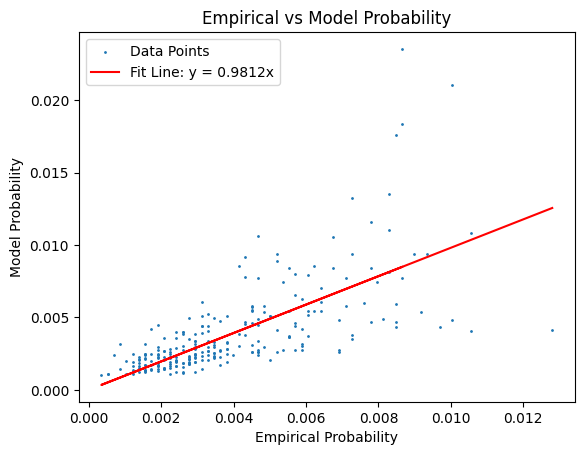

In [118]:
# Plot the results
from scipy.optimize import minimize, nnls
a, _ = nnls(P_empirical.reshape(-1, 1), P_model)
plt.scatter(P_empirical, P_model, s=1,label='Data Points')
plt.plot(P_empirical, a * P_empirical, color='red', label=f'Fit Line: y = {a[0]:.4f}x')
plt.xlabel('Empirical Probability')
plt.ylabel('Model Probability')
plt.title('Empirical vs Model Probability')
plt.legend()
plt.show()

# Estimation of the sizes of dominant brain states

In [78]:
basin = np.zeros(len(local_min_arg), dtype=object)
basin[:] = [[] for _ in range(len(local_min_arg))]  # Initialize basins as lists
n = ROI
for i in range(2**n):
    a = 1
    arg = i
    neig = np.where(dis_graph[i] == 1)[0]
    E_neig = E[neig]
    # print(f"Processing state: {i}, Neighbors: {neig}, Neighbor energies: {E_neig}")
    # print(i)

    while a == 1:
        if np.min(E_neig) in local_min_E:
            k = np.where(local_min_E == np.min(E_neig))[0]
            # print(k[0])
            basin[k[0]].append(i)  # Append state to the corresponding basin
            a = 0
        elif E[arg] > np.min(E_neig):
            arg = neig[np.argmin(E_neig)]
            neig = np.where(dis_graph[arg] == 1)[0]
            E_neig = E[neig]
        else:
            a = 0

print("Basins of attraction for local minima:")
for idx, b in enumerate(basin):
    print(f"Local minimum {local_min_arg[idx]} (Energy: {local_min_E[idx]}): States {b}")


Basins of attraction for local minima:
Local minimum 0 (Energy: -0.0): States [2, 16, 32, 48]
Local minimum 183 (Energy: -0.985400415340671): States [1, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 29, 31, 33, 34, 35, 36, 37, 38, 39, 47, 49, 50, 51, 52, 53, 54, 55, 65, 68, 69, 70, 71, 85, 87, 101, 103, 128, 129, 130, 131, 132, 133, 134, 135, 137, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 160, 161, 162, 163, 164, 165, 166, 167, 175, 176, 177, 178, 179, 180, 181, 182, 193, 196, 197, 198, 199, 231]
Local minimum 255 (Energy: -1.7428860916184776): States [8, 10, 24, 25, 26, 27, 28, 30, 40, 41, 42, 43, 44, 45, 46, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 136, 138, 142, 152, 153, 154, 155, 156, 157, 158, 159, 168, 169, 1

In [79]:
for i in range(len(local_min_arg)):
  print(i, local_min_arg[i], len(basin[i]))

0 0 4
1 183 88
2 255 161


In [80]:
len_basin = 0
for i in range(len(local_min_arg)):
  len_basin = len_basin + len(basin[i])
len_basin + len(local_min_arg)

256

In [82]:
# major_states = [local_min_arg[2], local_min_arg[0], local_min_arg[4]]
# minor_states = [local_min_arg[1], local_min_arg[3]]

# Random-walk simulation of brain dynamics

In [125]:
# Random walk parameters
num_steps = 100  # Total number of steps
discard_steps = 5  # Steps to discard
all_states = list(range(2**ROI))

current_state = np.random.randint(0, 2**ROI)
transitions = []
stays = {state: [] for state in all_states}
stay_durations = {state: 0 for state in all_states}
state_counts = {state: 0 for state in all_states}

for step in range(num_steps):
    # Get neighboring states and their energies
    neighbors = np.where(dis_graph[current_state] == 1)[0]
    neighbor_energies = E[neighbors]

    # Select a neighboring state based on the transition probability
    probabilities = np.minimum(1, np.exp(E[current_state] - neighbor_energies))
    probabilities /= np.sum(probabilities)
    next_state = np.random.choice(neighbors, p=probabilities)

    # Record the transition
    if step >= discard_steps:
        transitions.append((current_state, next_state))
        state_counts[current_state] += 1
        if current_state in stay_durations:
            stay_durations[current_state] += 1

    # Move to the next state
    current_state = next_state

# Calculate the transition frequency between the major and minor states
transition_freq = {state: {s: 0 for s in all_states} for state in all_states}
for (start, end) in transitions:
    if start in transition_freq and end in transition_freq[start]:
        transition_freq[start][end] += 1


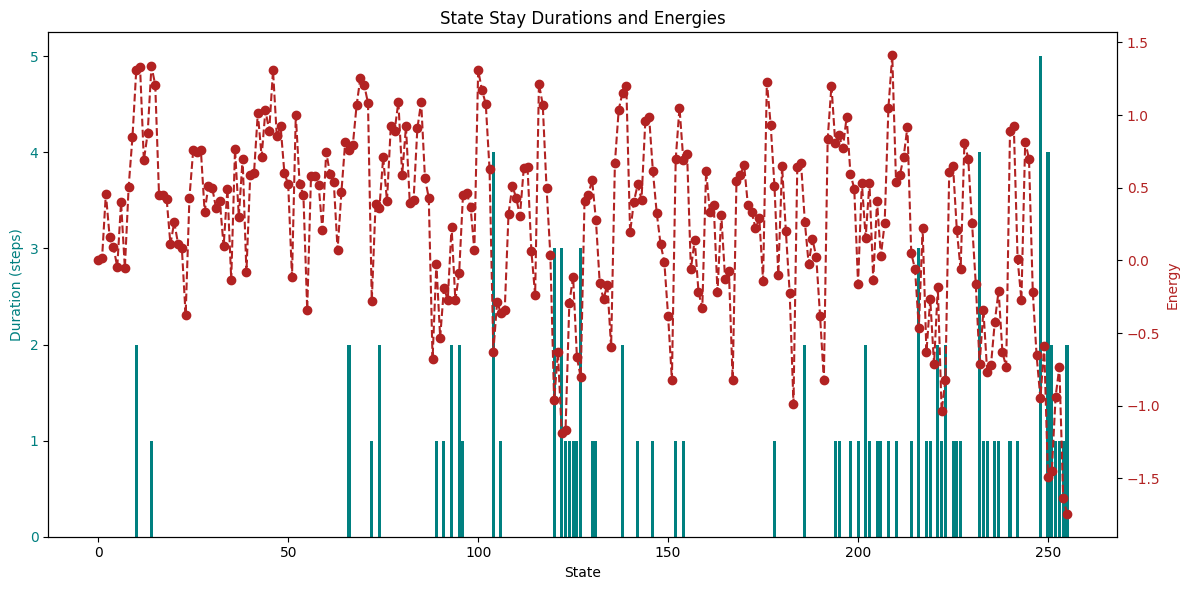

In [130]:
# -------------------------
# 📊 Plot durations and energies
# -------------------------
state_labels = list(stay_durations.keys())
durations = list(stay_durations.values())
energies = [E[s] for s in state_labels]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Line plot for energy (second axis)
ax2 = ax1.twinx()
ax2.plot(state_labels, energies, 'o--', color='firebrick', label='Energy')
ax2.set_ylabel('Energy', color='firebrick')
ax2.tick_params(axis='y', labelcolor='firebrick')


# Bar plot for stay durations
bars = ax1.bar(state_labels, durations, color='teal', label='Stay Duration')
ax1.set_xlabel('State')
ax1.set_ylabel('Duration (steps)', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')


# Titles and legends
plt.title('State Stay Durations and Energies')
fig.tight_layout()
plt.show()